In [12]:
import gym
import random
import numpy as np
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple, deque
%matplotlib inline

#### Буфер для experience replay

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = self.transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#### Шум, сгенерированный Ornstein-Uhlenbeck Process

In [14]:
class Noise:
    def __init__(self, params):
        self.mu = params.mu
        self.theta = params.theta
        self.sigma = params.sigma
        self.reset()

    def reset(self):
        self.state = np.full(params.action_dim, self.mu)

    def make_noise(self):
        state = self.state
        delta = self.theta *(self.mu - state) + self.sigma * np.random.randn(len(state))
        self.state = state + delta
        return self.state

#### Классы для Actor и Critic сетей и общей модели - Model

In [15]:
class Actor(nn.Module):
    def __init__(self, params):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(params.state_dim,  params.act_hid_1)
        self.fc2 = nn.Linear(params.act_hid_1, params.act_hid_2)
        self.fc3 = nn.Linear(params.act_hid_2,  params.action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, params):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(params.state_dim, params.crit_hid_1)
        self.fc2 = nn.Linear(params.crit_hid_1 + params.action_dim, params.crit_hid_2)
        self.fc3 = nn.Linear(params.crit_hid_2, 1)

    def forward(self, x, action):
        x = F.relu(self.fc1(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Model:
    def __init__(self, params):
        
        self.device = params.device
            
        self.actor = Actor(params).to(self.device)
        self.actor_target = Actor(params).to(self.device)
        self.critic = Critic(params).to(self.device) 
        self.critic_target = Critic(params).to(self.device)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=params.lr_actor)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=params.lr_critic)
        
        self.tau_actor = params.tau_actor
        self.tau_critic = params.tau_critic
        
        self.__update(self.actor_target, self.actor)
        self.__update(self.critic_target, self.critic)
        
    def __update(self, target, local):
        target.load_state_dict(local.state_dict())
        
    def __soft_update(self, target, local, tau):
        for target_param, param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
            
    def update_target_nn(self):
        self.__soft_update(self.actor_target, self.actor, self.tau_actor)
        self.__soft_update(self.critic_target, self.critic, self.tau_critic)   

#### Класс для DDPG

In [5]:
class DDPG:
    def __init__(self, params):
        
        self.device = params.device
        self.gamma = params.gamma
        self.batch_size = params.batch_size
        self.act_up, self.act_down = params.act_up, params.act_down 
        
        self.explor_noise = Noise(params) 
        self.buffer = ReplayBuffer(params.buffer_size)
        self.model = Model(params)
             

    def update(self):
        if len(self.buffer) <= self.batch_size:
            return

        transitions = self.buffer.sample(self.batch_size)
        batch = self.buffer.transition(*zip(*transitions))

        state_batch = self.tensor(batch.state).float()
        action_batch = self.tensor(batch.action).float()
        reward_batch = self.tensor(batch.reward).float()
        next_state_batch = self.tensor(batch.next_state).float()
        
        with torch.no_grad():
            next_actions = self.model.actor_target(next_state_batch)
        Q_next = self.model.critic_target(next_state_batch, next_actions).detach() 
        
        reward_batch = reward_batch.unsqueeze(1)
        not_terminate_batch = ~torch.tensor(batch.done).to(self.device).unsqueeze(1)
        
        Q = self.model.critic(state_batch, action_batch)
        Q_expected = reward_batch + self.gamma * Q_next * not_terminate_batch
        
        L = F.mse_loss(Q, Q_expected)
        self.model.critic_optimizer.zero_grad()
        L.backward()
        for param in self.model.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.critic_optimizer.step()
        
        a = self.model.actor(state_batch)
        L_policy = - self.model.critic(state_batch, a).mean()
        self.model.actor_optimizer.zero_grad()
        L_policy.backward()
        for param in self.model.actor.parameters():
            param.grad.data.clamp_(-1, 1) 
        self.model.actor_optimizer.step()
        
        self.model.update_target_nn()
        
    def act(self, state, eps=0):
        state = self.tensor(state).float().unsqueeze(0)
        with torch.no_grad():
            action = self.model.actor(state)
        return np.clip(action.item() + eps*self.explor_noise.make_noise(), self.act_down, self.act_up)

    def reset(self):
        self.explor_noise.reset()
        
    def tensor(self, x):
        return torch.tensor(x).to(self.device)

####  Обучение и тестирование агента

In [6]:
def training_agent(params, agent, plot=False):
    rewards = []
    for i in range(1, params.episodes+1):
        state = env.reset()
        agent.reset()
        params.update_eps()
        total_reward, steps = 0, 0
        done = False
        while not done:
            #env.render()
            action = agent.act(state, params.eps)

            next_state, reward, done, _ = env.step(action)
            modified_reward = params.mod_reward(reward, state, next_state)
            agent.buffer.push(state, action, next_state, modified_reward, done)
            state = next_state
            agent.update()

            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        print(f"Episode {i}, reward: {total_reward}")
        if total_reward > 95:
            score = params.check_rewards(agent)
            print(f"Local test score: {score}")
            if score > 95:
                break
    if plot:
        plt.plot(range(1, i+1), rewards)
        plt.ylabel("Reward")
        plt.xlabel("Episodes")
        plt.title("Training scores")
        plt.show()
    return agent

def test_agent(agent, plot=True):
    env_new = gym.make('MountainCarContinuous-v0')
    rewards = []
    for i in range(100):
        state = env_new.reset()
        total_reward, steps = 0, 0
        done = False
        while not done:
            #env_new.render()
            next_state, reward, done, _ = env_new.step(agent.act(state))
            total_reward += reward
            state = next_state
        rewards.append(total_reward)
    if plot:
        plt.plot(range(1,i+2), rewards)
        plt.ylabel("Reward")
        plt.xlabel("Episodes")
        plt.title("Test scores")
        plt.show()
    print("Mean score for 100 episodes:", np.mean(rewards))

#### Класс для настройки параметров модели

In [10]:
class Paramaters:
    def __init__(self, env):
        
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_up = env.action_space.high[0]
        self.act_down = env.action_space.low[0]

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 1
        self.gamma = 0.9
        self.episodes = 500
        self.max_steps = 1000
        self.batch_size = 256
        self.buffer_size = int(1e4)

        self.eps = 1.0
        self.eps_decay = 0.95
        self.eps_min = 0.01

        self.tau_actor = 0.1
        self.tau_critic = 0.3
        self.lr_actor = 1e-4
        self.lr_critic = 1e-3
        
        self.mu = 0
        self.theta = 0.15
        self.sigma = 0.2
        
        self.act_hid_1, self.act_hid_2 = 128, 128
        self.crit_hid_1, self.crit_hid_2 = 128, 128
        
        self.reward_coef = 20
        
        self.froze_seed()
        
    def froze_seed(self):
        env.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        
    def update_eps(self):
        self.eps = max(self.eps_min, self.eps*self.eps_decay)
    
    def mod_reward(self, reward, state, next_state):
        return reward + self.reward_coef * (self.gamma * abs(next_state[1]))
    
    def check_rewards(self, agent):
        env_new = gym.make('MountainCarContinuous-v0')
        rewards = []
        for _ in range(100):
            state = env_new.reset()
            total_reward, steps = 0, 0
            done = False
            while not done:
                next_state, reward, done, _ = env_new.step(agent.act(state))
                total_reward += reward
                state = next_state
            rewards.append(total_reward)
        return np.mean(rewards)

#### Обучение и тестирование агента

Episode 1, reward: 47.646574766374734
Episode 2, reward: -75.22981758481514
Episode 3, reward: -38.27702359453729
Episode 4, reward: 77.04664901092823
Episode 5, reward: 85.24546052941851
Episode 6, reward: 91.53811334181174
Episode 7, reward: 95.61325399230195
Local test score: 97.70085916820862


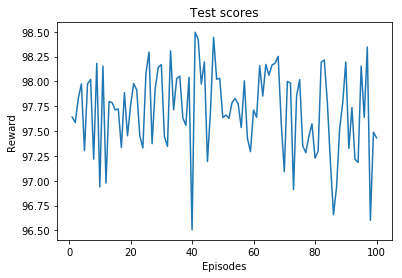

Mean score for 100 episodes: 97.71078852811551


In [11]:
env = gym.make('MountainCarContinuous-v0')

params = Paramaters(env)

Agent = DDPG(params)
Agent = training_agent(params, Agent)
test_agent(Agent)